In [1]:
%pip install imbalanced-learn
%pip install xgboost
%pip install shap
%pip install hyperopt
%pip install setuptools
from hyperopt import fmin, tpe, hp, Trials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
import shap
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve, make_scorer, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../datasets/data.csv')


Cross-Validation ROC-AUC Scores:
[0.99884319 0.99927094 0.99860465 0.99845074 0.99837983]
Mean ROC-AUC: 0.9987
Standard Deviation: 0.0003

Test Set Evaluation:

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1320
           1       0.46      0.57      0.51        44

    accuracy                           0.96      1364
   macro avg       0.72      0.77      0.75      1364
weighted avg       0.97      0.96      0.97      1364


Test Confusion Matrix:


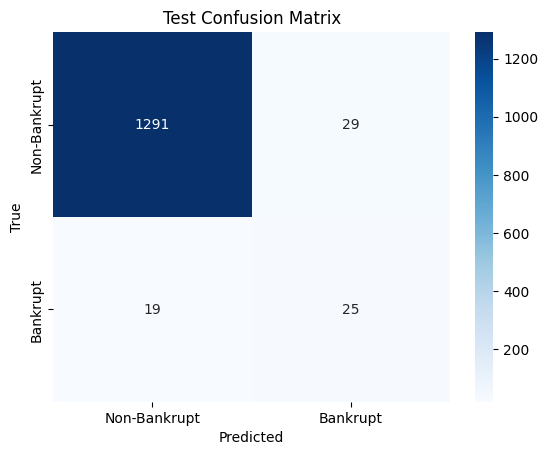

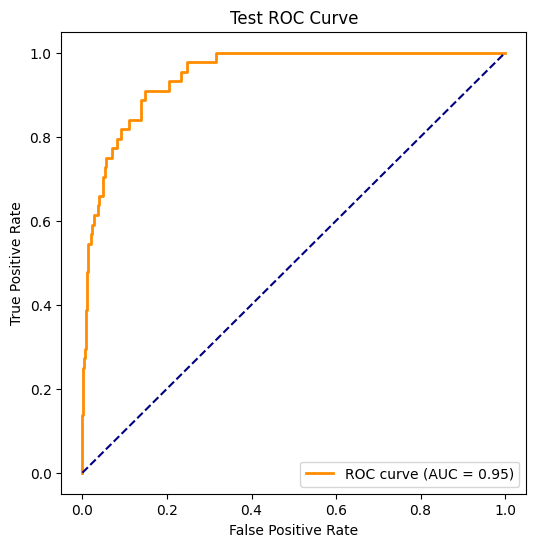

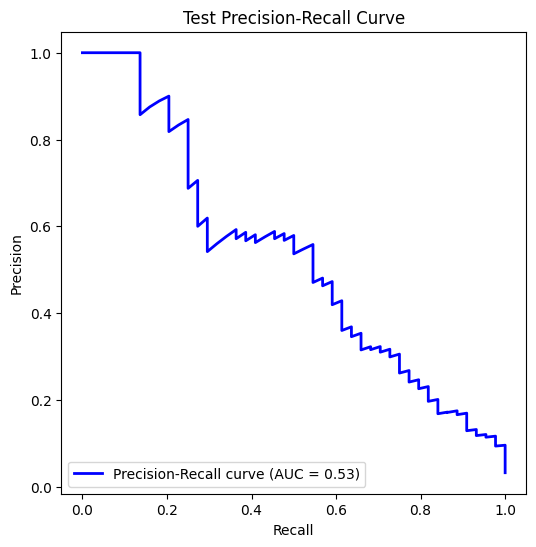

In [5]:
def evaluate_model(pipeline, X, y, dataset_name="Model"):
    y_pred = pipeline.predict(X)
    y_proba = pipeline.predict_proba(X)[:, 1]
    
    # Classification Report
    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    print(f"\n{dataset_name} Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bankrupt', 'Bankrupt'], 
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return plot_metrics(y, y_proba, dataset_name)

def plot_metrics(y, y_proba, dataset_name="Model"):
    """Plots ROC and Precision-Recall curves."""
    # ROC Curve measures the model's ability to distinguish between classes across all thresholds. v good for classifying rare events, eg. bankruptcy.
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    
    # Precision-Recall Curve focuses on the minority class and better when the dataset is imbalanced, cos it highlights the trade-off between precision (minimizing false positives) and recall (capturing true positives). 
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

    return {"roc_auc": roc_auc, "pr_auc": pr_auc}



# ------------------- Preparing the Data --------------------
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']


X_imputed = SimpleImputer(strategy='median').fit_transform(X)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42) #to generates synthetic samples for the minority class to balance the dataset
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)



# ------------------- Creating the Models --------------------
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced') #good for overfitting
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=(len(y_train_res[y_train_res == 0]) / len(y_train_res[y_train_res == 1]))) #good for imbalanced datasets

voting_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')



# pipeline automates preprocessing (scaling) and model fitting, ensuring reproducibility and reducing the risk of data leakage between training and testing.
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('voting_model', voting_model)
])



# ------------------- Cross-Validation --------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #ensuring model’s consistency across different subsets of the data
cv_scores = cross_val_score(pipeline, x_train_res, y_train_res, scoring='roc_auc', cv=cv, n_jobs=-1)

print("\nCross-Validation ROC-AUC Scores:")
print(cv_scores)
print(f"Mean ROC-AUC: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")





# ------------------- Training and Evaluation --------------------
# Train the model on the entire training data
pipeline.fit(x_train_res, y_train_res) 

# Evaluate on test set
print("\nTest Set Evaluation:")
test_metrics = evaluate_model(pipeline, x_test, y_test, dataset_name="Test")